In [1]:
import numpy as np
import numexpr as ne
from math import pi
from scipy.optimize import newton
from scipy.signal import hilbert
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

from novice_stakes.surfaces import Surface, spectrum
from novice_stakes import initialize_nuttall
from novice_stakes.refraction import p_sca_KA_fan, IsoSpeedFan, initialize_axes

In [16]:
z_src = -3800.
z_rcr = -200.
x_rcr = 3800.

# Lorentzian surface parameters
rms_height = 0.1
corr_length = 20

# compute time/frequency domain parameters
c = 1500
fc = 4e3
fs = 2.1 * fc * 2
tau_lim = 30e-3

faxis, dx, sig_FT = initialize_nuttall(fc, fs, c, tau_lim)
fi = np.argmin(np.abs(faxis - fc))
kmax = 2 * pi / dx

# compute source and receiver ray fans
dz_iso = 2
num_rays = 2000
theta_max = 0.1 * (pi / 180)

ray_src = IsoSpeedFan(c, z_src + dz_iso, num_rays, theta_max)
ray_rcr = IsoSpeedFan(c, z_rcr + dz_iso, num_rays, theta_max)

# setup xaxis
xaxis, yaxis, tau_img = initialize_axes(ray_src, ray_rcr, tau_lim, x_rcr, dx, dz_iso=dz_iso)

kx = np.arange(xaxis.size // 2 + 1) * kmax / xaxis.size
ky = (np.arange(yaxis.size) - (yaxis.size // 2 - 1)) * kmax / yaxis.size

In [17]:
Pxx = spectrum.lorentzian(kx, rms_height, corr_length)
surf_1D = Surface(kmax, Pxx)

realization_1D = surf_1D.realization()
eta = surf_1D.surface_synthesis(realization_1D)
eta_p = surf_1D.surface_synthesis(realization_1D, derivative='x')

p_rcr, taxis, p_ref = p_sca_KA_fan(ray_src, ray_rcr, xaxis, x_rcr,
                                   eta, eta_p, tau_img, tau_lim, 
                                   faxis, sig_FT, dz_iso=dz_iso)


Text(0, 0.5, 'Magnitude')

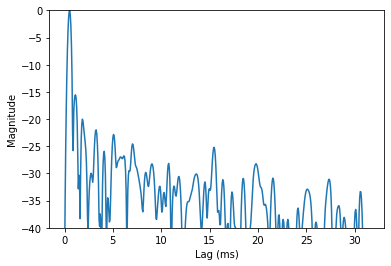

In [18]:
p_dB = 20 * np.log10(np.abs(hilbert(p_rcr))) - 20 * np.log10(p_ref)
fig, ax = plt.subplots()
ax.plot((taxis - tau_img) * 1e3, p_dB)
ax.set_ylim(-40, 0)
ax.set_xlabel('Lag (ms)')
ax.set_ylabel('Magnitude')